# Prediction
This section of the project aims to identify a prediction algorithm that can accurately suggest two values: shID (short acting insulin dose) based on input features, and BG2 (after-meal blood glucose) based on both the input features and predicted shID. Various machine learning tasks, such as regression and classification, will be performed and compared to determine the most effective approach.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Style configuration

In [70]:
#Colors
background = '#F0F0F0'
red = '#ED462F'
pink = '#F1BBB8'
green = '#4CB866'
blue = '#003D83'
black = '#333333'
grey = '#C6D0D2'

#Matplotlib configurations

plt.rcParams.update({'axes.facecolor' : grey,
                     'axes.edgecolor': background,   
                     'axes.linewidth': 2,
                     'figure.facecolor' : grey,
                     'font.family' : 'monospace',
                     'xtick.color' : background,
                     'ytick.color' : background,
                     'xtick.labelcolor' : '#8C9496',
                     'ytick.labelcolor' : '#8C9496',
                     'legend.labelcolor' : '#8C9496'
                     })




In [50]:
from matplotlib.colors import LinearSegmentedColormap

# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('', [background,red])

### Preparing data

#### Read data

In [3]:
# Read the data in csv format
df = pd.read_csv('/Users/polzovatel/Desktop/Python/Portfolio/Diabetes_3/1_2_Preprocessing/FullData_preprocessed.csv')
df

,Date,Interval,DV,BG1,BG2,bID,shID,SC,Temp,Humid
0,2022-12-09 07:00:00,B-L,1.756,4.7,4.7,3.0,3.5,1820,-16,74
1,2022-12-09 18:00:00,D-B,3.442,4.3,6.5,2.0,4.0,18,-12,69
2,2022-12-10 07:00:00,B-L,1.584,6.5,5.6,3.0,4.0,2607,-13,77
3,2022-12-10 12:00:00,L-D,2.562,5.6,6.2,2.5,2.0,2067,-12,66
4,2022-12-10 18:00:00,D-B,4.190,6.2,6.1,2.0,3.5,487,-12,66
...,...,...,...,...,...,...,...,...,...,...
198,2023-02-24 12:00:00,L-D,2.194,6.5,6.2,3.0,3.0,1715,-10,66
199,2023-02-24 18:00:00,D-B,2.389,6.2,5.1,3.0,2.5,0,-9,66
200,2023-02-25 07:00:00,B-L,1.706,5.1,6.7,3.0,3.0,1505,-15,65
201,2023-02-25 12:00:00,L-D,1.952,6.7,3.8,3.0,3.0,68,-11,56


#### Filter and partition data

In [4]:
# Retrieve only the rows where the post-meal blood glucose level falls within the normal range.
df_norm_BG2 = df[(df['BG2']>3.9)&(df['BG2']<5.5)].reset_index(drop=True)
df_norm_BG2

,Date,Interval,DV,BG1,BG2,bID,shID,SC,Temp,Humid
0,2022-12-09 07:00:00,B-L,1.756,4.7,4.7,3.0,3.5,1820,-16,74
1,2022-12-11 18:00:00,D-B,2.639,7.1,4.2,2.0,3.5,20,-13,63
2,2022-12-12 07:00:00,B-L,1.763,4.2,5.1,3.0,3.5,2430,-19,79
3,2022-12-12 18:00:00,D-B,2.740,6.6,5.3,2.0,3.5,12,-11,56
4,2022-12-13 07:00:00,B-L,1.834,5.3,4.8,3.0,3.5,2392,-14,81
...,...,...,...,...,...,...,...,...,...,...
108,2023-02-22 12:00:00,L-D,2.105,4.3,4.3,3.0,2.5,5812,-10,48
109,2023-02-23 07:00:00,B-L,1.872,3.8,4.4,3.0,3.0,2249,-16,72
110,2023-02-23 18:00:00,D-B,2.376,5.9,4.6,3.0,2.5,20,-6,61
111,2023-02-24 18:00:00,D-B,2.389,6.2,5.1,3.0,2.5,0,-9,66


In [5]:
# Partitioning based on the interval
df_BL = df_norm_BG2[df_norm_BG2['Interval']=='B-L']
df_LD = df_norm_BG2[df_norm_BG2['Interval']=='L-D']
df_DB = df_norm_BG2[df_norm_BG2['Interval']=='D-B']

In [6]:
# Assigning names for future referencing in the loops
df_BL.name = 'Interval_breakfast-lunch'
df_LD.name = 'Interval_lunch-dinner'
df_DB.name = 'Interval_dinner-breakfast'

In [7]:
# A list of created sub-dataframes
dfs = [df_BL,df_LD,df_DB]

### Regression - target shID

Given that the features exhibit low correlation, indicating a non-linear relationship with the target label, the DecisonTreeRegressor and the RandomForestRegressor were selected as the appropriate models for this case. This decision is based on thier ability to capture complex, non-linear patterns in the data, making it well-suited for the prediction task at hand.

In [8]:
# Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [9]:
# Create an instance of a scaler
scaler = MinMaxScaler()

#### DecisionTreeRegressor

In [10]:
# Create an instance of the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=101)

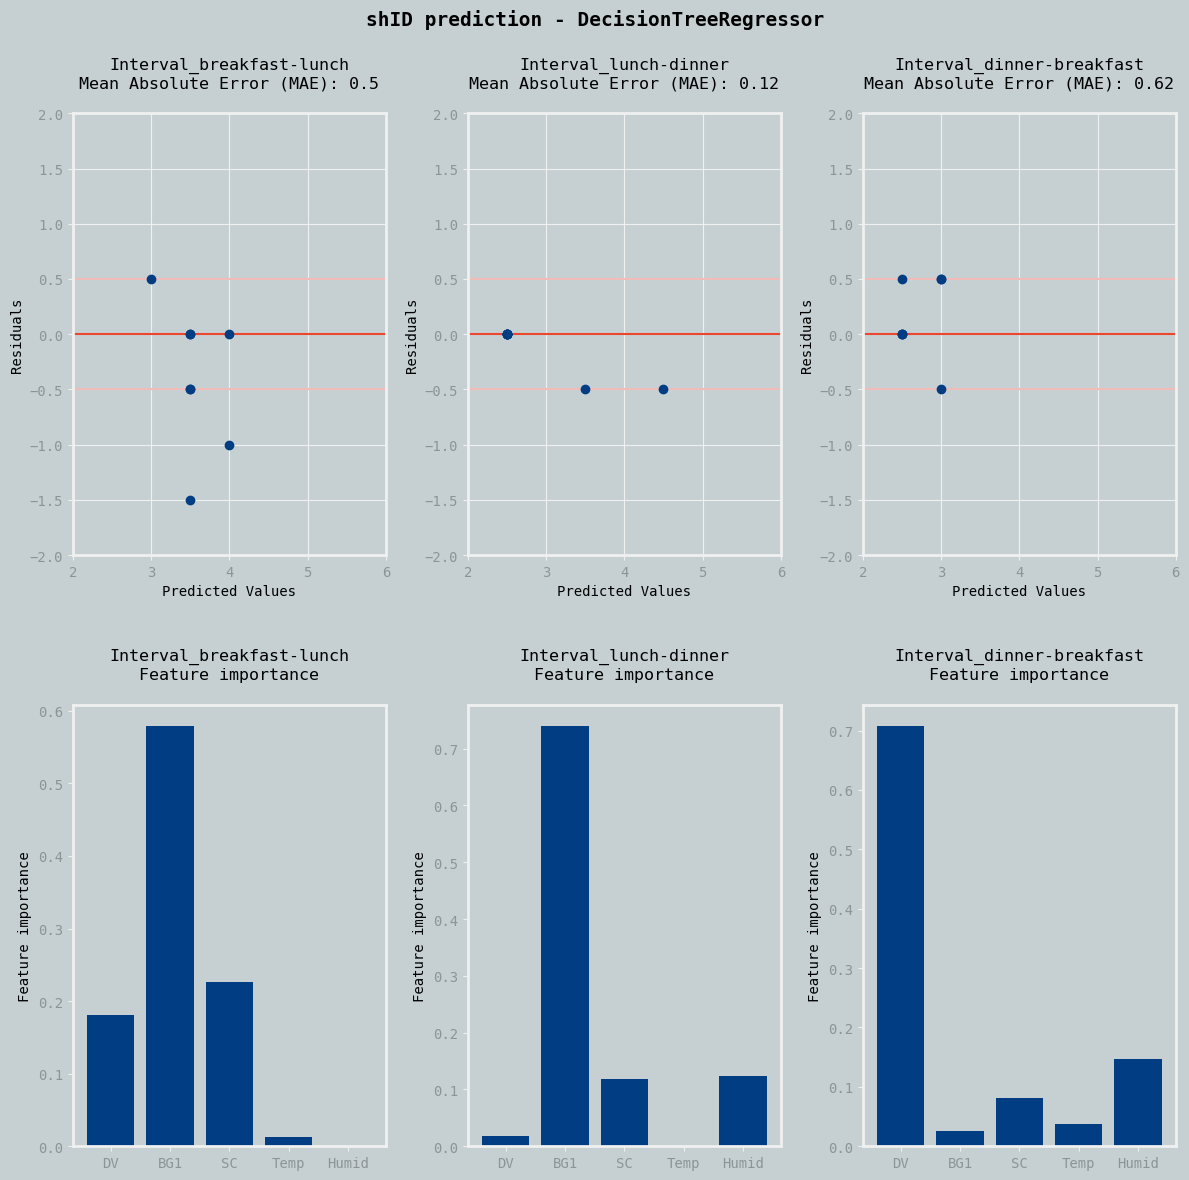

In [102]:
# Train the DecisionTreeRegressor, predict shID values and evaluate the model's performance across three intervals
## Create figure and axes
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(12,12))
ax = 0
fig.suptitle('shID prediction - DecisionTreeRegressor\n', fontsize=14, fontweight='bold')

## Iterate through a list of data frames for each interval
for d in dfs:
    
    ## Specify features X and label y 
    X = d[['DV','BG1','SC','Temp','Humid']] 
    y = d['shID']
    
    ## Scale data
    scaled_X = scaler.fit_transform(X)
    
    ## Train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=101)
    
    ## Fit the model
    dt_reg.fit(X_train, y_train)
    
    ## Predict the label
    y_pred = dt_reg.predict(X_test)
    
    ## Get evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    residuals = y_test - y_pred
    importances = dt_reg.feature_importances_
    
    ## Plot predicted values vs residuals
    axes[0,ax].grid(color=background)
    axes[0,ax].scatter(y_pred, residuals,color=blue,zorder=10)
    axes[0,ax].axhline(y=0, color=red, linestyle='-')
    axes[0,ax].axhline(y= 0.5, color=pink, linestyle='-')
    axes[0,ax].axhline(y=-0.5, color=pink, linestyle='-')
    axes[0,ax].set_ylim(-2,2)
    axes[0,ax].set_xlim(2,6)
    axes[0,ax].set_xlabel('Predicted Values')
    axes[0,ax].set_ylabel('Residuals')
    axes[0,ax].set_title(f"{d.name}\nMean Absolute Error (MAE): {round(mae,2)}\n")
    
    ## Plot feature importance
    axes[1,ax].set_title(f'\n\n{d.name}\nFeature importance\n')
    axes[1,ax].set_ylabel(f'Feature importance')
    axes[1,ax].bar(X.columns, importances, width=0.8,color=blue)

    ## Move to the next column of the figure
    ax += 1

plt.tight_layout()

#### Results

Before evaluating the performance of the model, it is crucial to establish the acceptable threshold for the shID residual. In this case, the threshold was set within the range of -0.5 to 0.5, indicating that residuals falling within this range are considered acceptable.

The visualization above demonstrates that all the predictions remained within the specified threshold. However, when examining the mean absolute error across the intervals, it is evident that it varied, exceeding 0.5 during the dinner-breakfast interval.

Furthermore, a noteworthy observation is the variation in feature importance across intervals, particularly the changing roles of BG1 and DV. During the breakfast-lunch and lunch-dinner intervals, BG1 exhibits greater influence, while DV assumes a more significant role during the dinner-breakfast interval. It is also evident that some of the features (for example Humid at breakfast-lunch, or Temp at lunch-dinner) were not considered by the algorithm)

#### RandomForestRegressor

In [18]:
# Create an instance of the RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=101)

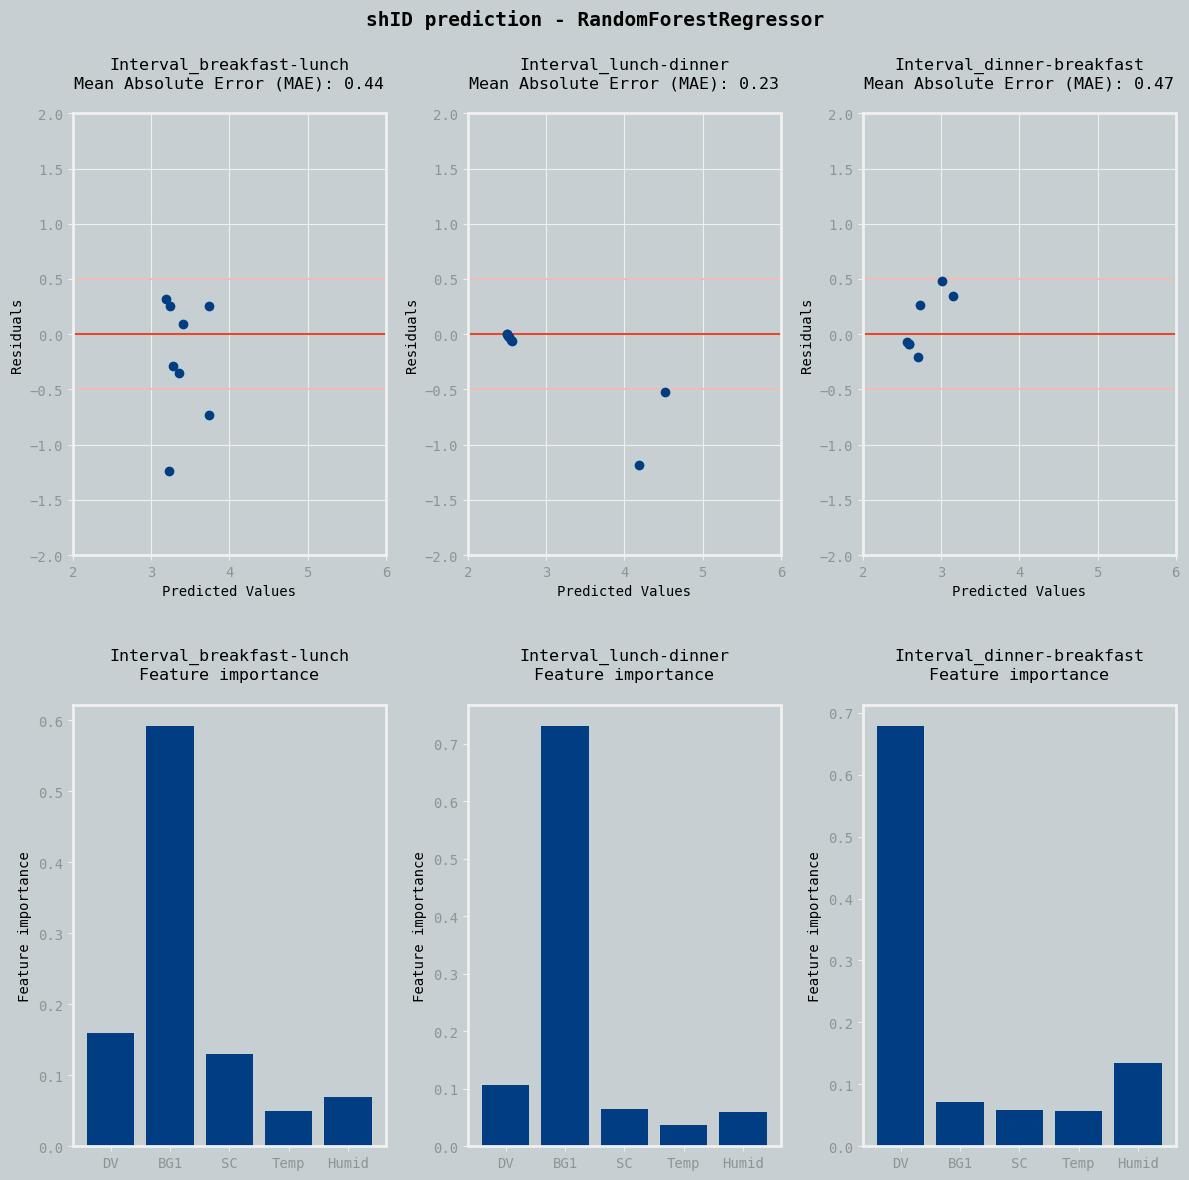

In [103]:
# Train the RandomForestRegressor, predict shID values and evaluate the model's performance across three intervals
## Create figure and axes
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(12,12))
ax = 0
fig.suptitle('shID prediction - RandomForestRegressor\n', fontsize=14, fontweight='bold')

## Iterate through a list of data frames for each interval
for d in dfs:
    
    ## Specify features X and label y 
    X = d[['DV','BG1','SC','Temp','Humid']] 
    y = d['shID']
    
    ## Scale data
    scaled_X = scaler.fit_transform(X)
    
    ## Train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=101)
    
    ## Fit the model
    rf_reg.fit(X_train, y_train)
    
    ## Predict the label
    y_pred = rf_reg.predict(X_test)
    
    ## Get evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    residuals = y_test - y_pred
    importances = rf_reg.feature_importances_
    
    ## Plot predicted values vs residuals
    axes[0,ax].grid(color=background)
    axes[0,ax].scatter(y_pred, residuals,color=blue,zorder=10)
    axes[0,ax].axhline(y=0, color=red, linestyle='-')
    axes[0,ax].axhline(y= 0.5, color=pink, linestyle='-')
    axes[0,ax].axhline(y=-0.5, color=pink, linestyle='-')
    axes[0,ax].set_ylim(-2,2)
    axes[0,ax].set_xlim(2,6)
    axes[0,ax].set_xlabel('Predicted Values')
    axes[0,ax].set_ylabel('Residuals')
    axes[0,ax].set_title(f"{d.name}\nMean Absolute Error (MAE): {round(mae,2)}\n")
    
    ## Plot feature importance
    axes[1,ax].set_title(f'\n\n{d.name}\nFeature importance\n')
    axes[1,ax].set_ylabel(f'Feature importance')
    axes[1,ax].bar(X.columns, importances, width=0.8,color=blue)

    ## Move to the next column of the figure
    ax += 1

plt.tight_layout()

#### Results

The majority of the predicted values from the RandomForestRegressor fell within the defined threshold, indicating its ability to provide accurate predictions with lower mean absolute errors. Additionally, the algorithm demonstrated a broader consideration of features, as evident from the graph. Interestingly, the influence of BG1 remained prominent during the breakfast-lunch and lunch-dinner intervals, while DV continued to play a significant role during the dinner-breakfast interval.

### Classification - target shID

Considering the relatively low number of unique values in the target label, it may be more appropriate to implement a classification algorithm instead. This shift can potentially improve the accuracy and effectiveness of the model in predicting the discrete categories of the target variable.

#### Prepare data

<AxesSubplot: xlabel='Interval', ylabel='count'>

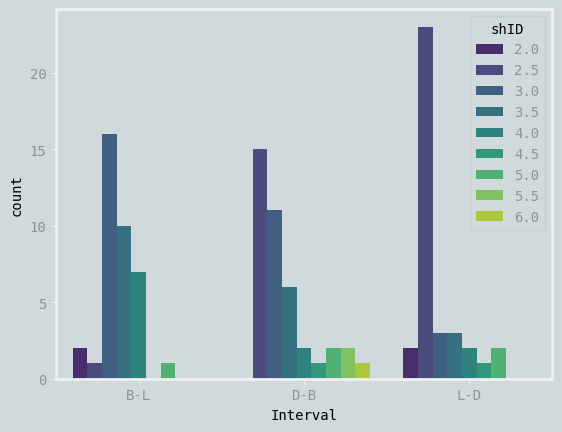

In [23]:
# Explore the ['shID'] values throughout the dataframe
sns.countplot(data=df_norm_BG2,x='Interval',hue='shID',palette='viridis')

Due to the uneven distribution of values, there is a possibility that the classification algorithm may encounter challenges in performance. However, a potential solution to address this issue is to create new classes by consolidating values into meaningful groups. This approach can help improve the performance of the classification algorithm by establishing more balanced and distinguishable categories. By strategically grouping the values, the algorithm can potentially achieve better accuracy and predictive power, enabling more effective classification of the target variable.

In [24]:
# Explore the count per unique value in df_BL
df_BL.groupby('shID').count()

,Date,Interval,DV,BG1,BG2,bID,SC,Temp,Humid
shID,,,,,,,,,
2.0,2,2,2,2,2,2,2,2,2
2.5,1,1,1,1,1,1,1,1,1
3.0,16,16,16,16,16,16,16,16,16
3.5,10,10,10,10,10,10,10,10,10
4.0,7,7,7,7,7,7,7,7,7
5.0,1,1,1,1,1,1,1,1,1


In [25]:
# Create shID classes for df_BL
df_BL_classes = ['<=3' if value<=3 else '>=3.5' for value in df_BL['shID']]

In [26]:
# Explore the count per unique value in the list of classes
count_dict = {}

for element in df_BL_classes:
    if element in count_dict:
        count_dict[element] += 1
    else:
        count_dict[element] = 1

for element, count in count_dict.items():
    print(f"{element}: {count}")

>=3.5: 18
<=3: 19


In [27]:
# Explore the count per unique value in df_LD
df_LD.groupby('shID').count()

,Date,Interval,DV,BG1,BG2,bID,SC,Temp,Humid
shID,,,,,,,,,
2.0,2,2,2,2,2,2,2,2,2
2.5,23,23,23,23,23,23,23,23,23
3.0,3,3,3,3,3,3,3,3,3
3.5,3,3,3,3,3,3,3,3,3
4.0,2,2,2,2,2,2,2,2,2
4.5,1,1,1,1,1,1,1,1,1
5.0,2,2,2,2,2,2,2,2,2


In [28]:
# Create shID classes for df_LD
df_LD_classes = ['<=2.5' if value<=2.5 else '>=3' for value in df_LD['shID']]

In [29]:
# Explore the count per unique value in the list of classes
count_dict = {}

for element in df_LD_classes:
    if element in count_dict:
        count_dict[element] += 1
    else:
        count_dict[element] = 1

for element, count in count_dict.items():
    print(f"{element}: {count}")

<=2.5: 25
>=3: 11


In [30]:
# Explore the count per unique value in df_DB
df_DB.groupby('shID').count()

,Date,Interval,DV,BG1,BG2,bID,SC,Temp,Humid
shID,,,,,,,,,
2.5,15,15,15,15,15,15,15,15,15
3.0,11,11,11,11,11,11,11,11,11
3.5,6,6,6,6,6,6,6,6,6
4.0,2,2,2,2,2,2,2,2,2
4.5,1,1,1,1,1,1,1,1,1
5.0,2,2,2,2,2,2,2,2,2
5.5,2,2,2,2,2,2,2,2,2
6.0,1,1,1,1,1,1,1,1,1


In [31]:
# Create shID classes for df_DB
df_DB_classes = ['<=3' if value<=3 else '>=3.5' for value in df_DB['shID']]

In [32]:
# Explore the count per unique value in the list of classes
count_dict = {}

for element in df_DB_classes:
    if element in count_dict:
        count_dict[element] += 1
    else:
        count_dict[element] = 1

for element, count in count_dict.items():
    print(f"{element}: {count}")

>=3.5: 14
<=3: 26


In [33]:
classes = [df_BL_classes, df_LD_classes, df_DB_classes]

#### Perform classification

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [35]:
# Create instances of models
lg = LogisticRegression(random_state=101)
dt = DecisionTreeClassifier(random_state=101)
rf = RandomForestClassifier(random_state=101)

In [36]:
# A list of models
models = [lg,dt,rf]

In [76]:
models

[LogisticRegression(random_state=101),
 DecisionTreeClassifier(random_state=101),
 RandomForestClassifier(random_state=101)]

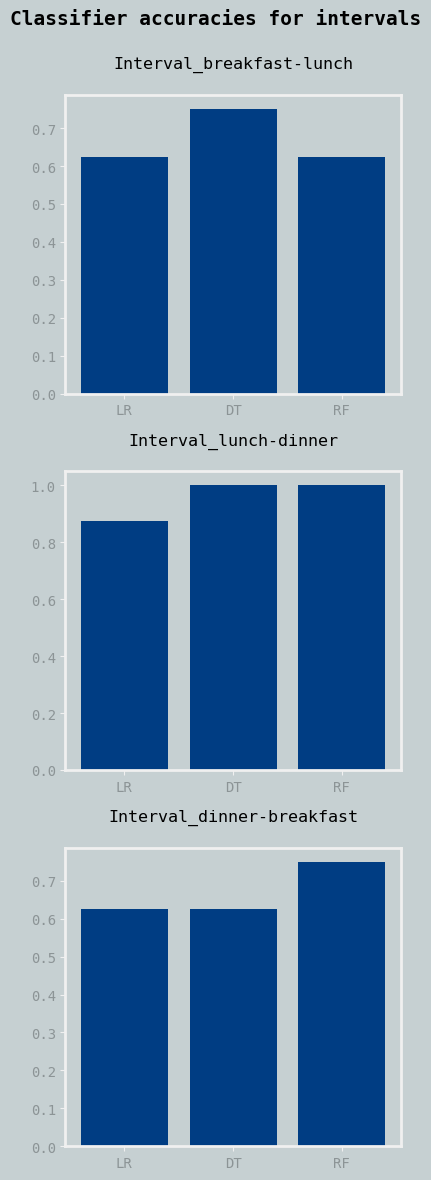

In [97]:
# Preprocess data, train model, predict label and evaluate performance
## Create figures and axes
fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(4,12))
ax=0
fig.suptitle('Classifier accuracies for intervals\n', fontsize=14, fontweight='bold')

## Iterate through dfs and classes
for d,c in zip(dfs,classes):
    
    ## Prepare X features and y label
    X = d[['DV','BG1','SC','Temp','Humid']]
    y = c
    
    ## Scale data
    scaled_X = scaler.fit_transform(X)
    
    ## Train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=101)
    
    ## Train each model, predict label and get the accuracy score
    accuracies = []
    model_names = []
    for m in models:
    
        m.fit(X_train, y_train)

        y_pred = m.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        model_names.append(str(m))
        
    ## Plot accuracies
    axes[ax].bar(model_names,accuracies,color=blue)
    axes[ax].set_xticks(axes[ax].get_xticks())
    axes[ax].set_xticklabels(['LR','DT','RF'])
    axes[ax].set_title(f'{d.name}\n')
    ax+=1
    
plt.tight_layout()  

Based on the accuracy scores, the RandomForestClassifier as well as DecisionTreeClassifier demonstrated a slight advantage over LogisticRegression. Given its reputation for effectively capturing complex relationships between features and the target variable, the RandomForestClassifier was deemed suitable for further analysis.

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

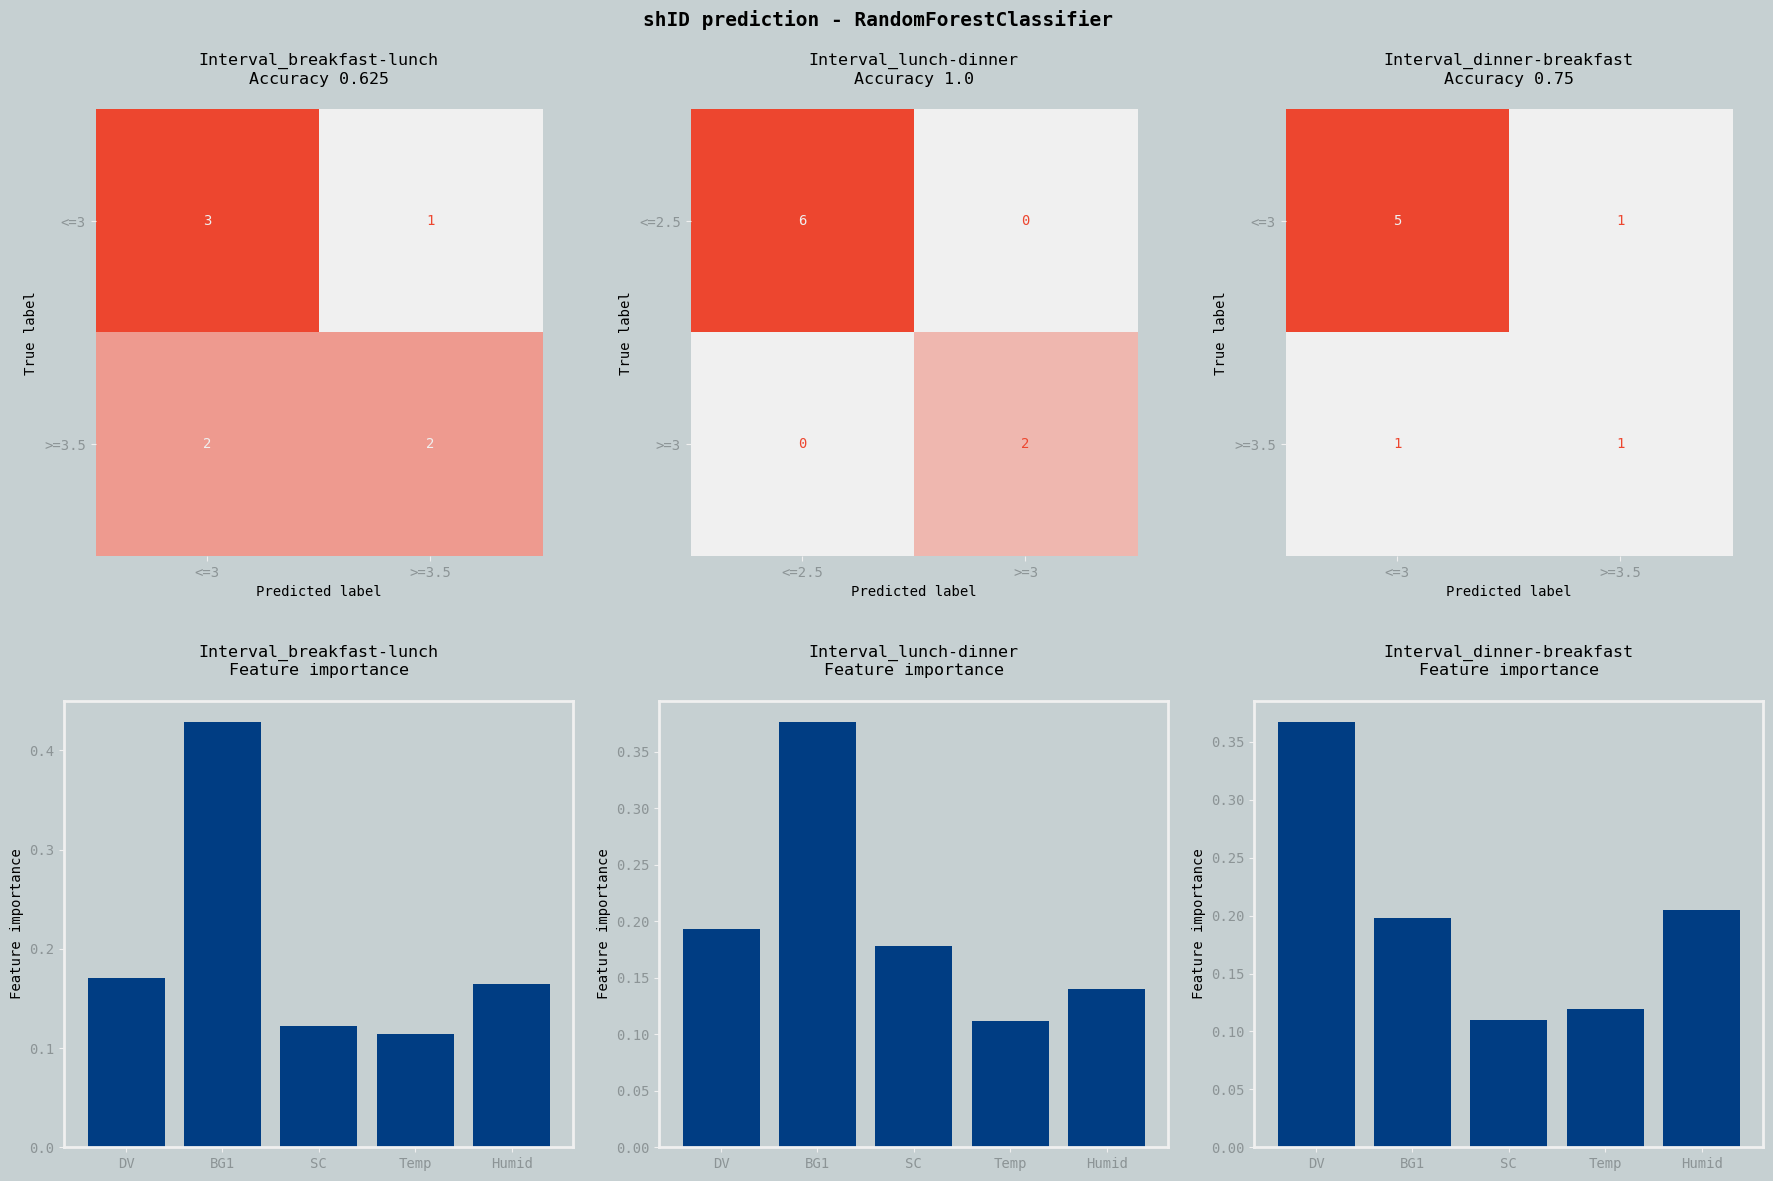

In [99]:
# Preprocess data, train model, predict label and evaluate performance
## Create figure and axes
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(18,12))
ax = 0
fig.suptitle('shID prediction - RandomForestClassifier\n', fontsize=14, fontweight='bold')

## Iterate through dfs and classes
for d,c in zip(dfs,classes):
    
    ## Define X features and y classes
    X = d[['DV','BG1','SC','Temp','Humid']]
    y = c
    
    ## Scale data
    scaled_X = scaler.fit_transform(X)
    
    ## Train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=101)
    
    ## Train the model
    rf.fit(X_train, y_train)
    
    ## Predict values
    y_pred = rf.predict(X_test)

    ## Get evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)  
    importances = rf.feature_importances_
    
    ## Plot true lables vs predicted labels
    cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
    disp.plot(ax=axes[0,ax],colorbar=False,cmap=cmap)
    axes[0,ax].set_title(f'{d.name}\nAccuracy {accuracy}\n')
    axes[0,ax].grid(False)
    axes[0,ax].spines[['top','bottom','right','left']].set_visible(False)
    
    ## Plot feature importance
    axes[1,ax].set_title(f'\n\n{d.name}\nFeature importance\n')
    axes[1,ax].set_ylabel(f'Feature importance')
    axes[1,ax].bar(X.columns, importances, width=0.8,color=blue)

    ## Move to the next column of the figure
    ax += 1
    
plt.tight_layout();

#### Results

The classification algorithm performed well in predicting the shID, achieving high accuracy scores overall. The analysis of feature importance further supported the observation that BG1 had a significant impact during the breakfast-lunch and lunch-dinner intervals, while DV emerged as a more influential feature during the dinner-breakfast interval. 

While the classification approach demonstrated satisfactory results, it is important to consider the scalability and practicality of creating classes for individual patients. This process would require additional analysis and grouping of shID values, which may pose challenges in real-world applications. 

### Regression - target BG2

By obtaining a predicted shID value, it becomes feasible to predict the corresponding after-meal blood glucose level, BG2. This prediction can provide valuable insights for patients, enabling them to make more informed decisions regarding their insulin dose. 

Both the DecisionTreeRegressor and RandomForestRegressor algorithms were compared in a similar manner as done for the shID variable.

#### DecisionTreeRegressor

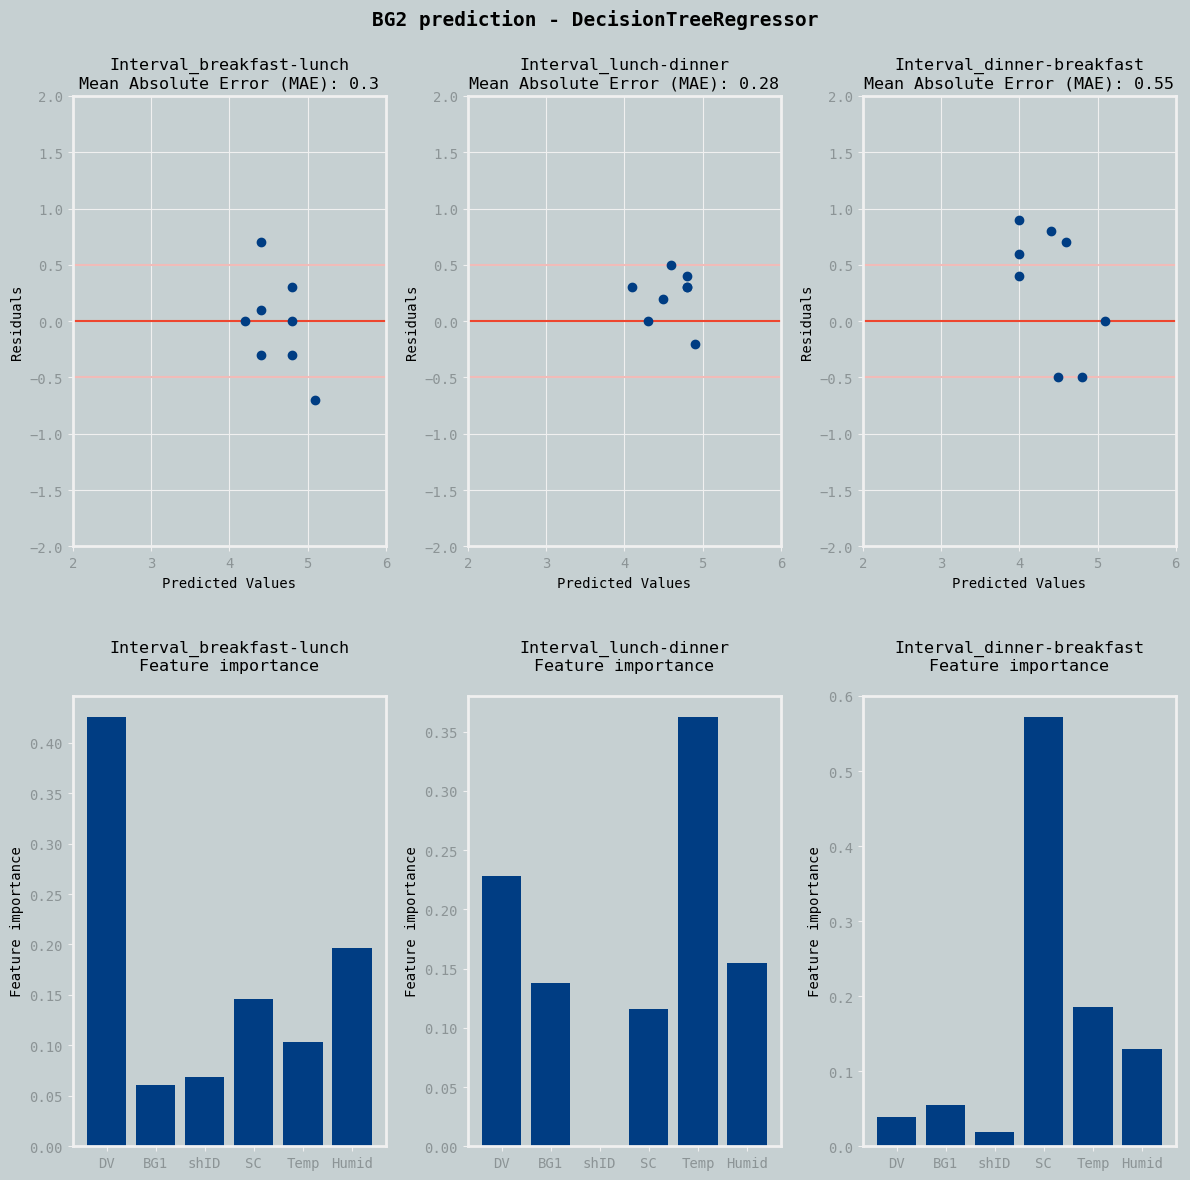

In [104]:
# Train the DecisionTreeRegressor, predict shID values and evaluate the model's performance across three intervals
## Create figure and axes
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(12,12))
ax = 0
fig.suptitle('BG2 prediction - DecisionTreeRegressor\n', fontsize=14, fontweight='bold')

## Iterate through a list of data frames for each interval
for d in dfs:
    
    ## Specify features X and label y 
    X = d[['DV','BG1','shID','SC','Temp','Humid']] 
    y = d['BG2']
    
    ## Scale data
    scaled_X = scaler.fit_transform(X)
    
    ## Train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=101)
    
    ## Fit the model
    dt_reg.fit(X_train, y_train)
    
    ## Predict the label
    y_pred = dt_reg.predict(X_test)
    
    ## Get evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    residuals = y_test - y_pred
    importances = dt_reg.feature_importances_
    
    ## Plot predicted values vs residuals
    axes[0,ax].grid(color=background)
    axes[0,ax].scatter(y_pred, residuals,color=blue,zorder=10)
    axes[0,ax].axhline(y=0, color=red, linestyle='-')
    axes[0,ax].axhline(y= 0.5, color=pink, linestyle='-')
    axes[0,ax].axhline(y=-0.5, color=pink, linestyle='-')
    axes[0,ax].set_ylim(-2,2)
    axes[0,ax].set_xlim(2,6)
    axes[0,ax].set_xlabel('Predicted Values')
    axes[0,ax].set_ylabel('Residuals')
    axes[0,ax].set_title(f"{d.name}\nMean Absolute Error (MAE): {round(mae,2)}")
    
    ## Plot feature importance
    axes[1,ax].set_title(f'\n\n{d.name}\nFeature importance\n')
    axes[1,ax].set_ylabel(f'Feature importance')
    axes[1,ax].bar(X.columns, importances, width=0.8,color=blue)

    ## Move to the next column of the figure
    ax += 1

plt.tight_layout()

#### RandomForestRegressor

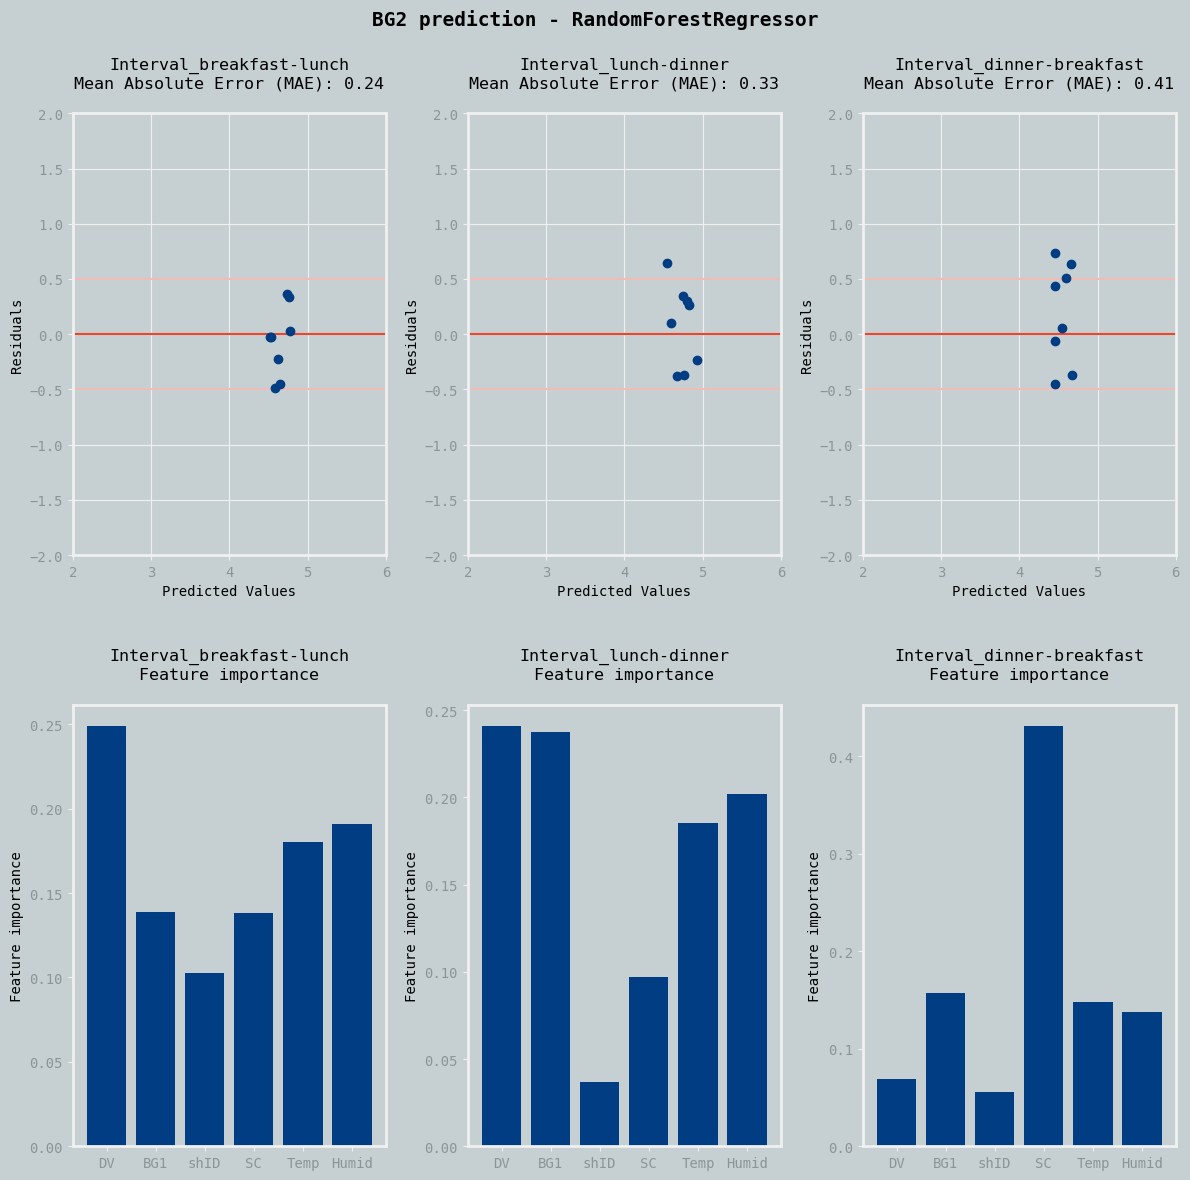

In [105]:
# Train the RandomForestRegressor, predict shID values and evaluate the model's performance across three intervals
## Create figure and axes
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(12,12))
ax = 0
fig.suptitle('BG2 prediction - RandomForestRegressor\n', fontsize=14, fontweight='bold')

## Iterate through a list of data frames for each interval
for d in dfs:
    
    ## Specify features X and label y 
    X = d[['DV','BG1','shID','SC','Temp','Humid']] 
    y = d['BG2']
    
    ## Scale data
    scaled_X = scaler.fit_transform(X)
    
    ## Train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=101)
    
    ## Fit the model
    rf_reg.fit(X_train, y_train)
    
    ## Predict the label
    y_pred = rf_reg.predict(X_test)
    
    ## Get evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    residuals = y_test - y_pred
    importances = rf_reg.feature_importances_
    
    ## Plot predicted values vs residuals
    axes[0,ax].grid(color=background)
    axes[0,ax].scatter(y_pred, residuals,color=blue,zorder=10)
    axes[0,ax].axhline(y=0, color=red, linestyle='-')
    axes[0,ax].axhline(y= 0.5, color=pink, linestyle='-')
    axes[0,ax].axhline(y=-0.5, color=pink, linestyle='-')
    axes[0,ax].set_ylim(-2,2)
    axes[0,ax].set_xlim(2,6)
    axes[0,ax].set_xlabel('Predicted Values')
    axes[0,ax].set_ylabel('Residuals')
    axes[0,ax].set_title(f"{d.name}\nMean Absolute Error (MAE): {round(mae,2)}\n")
    
    ## Plot feature importance
    axes[1,ax].set_title(f'\n\n{d.name}\nFeature importance\n')
    axes[1,ax].set_ylabel(f'Feature importance')
    axes[1,ax].bar(X.columns, importances, width=0.8,color=blue)

    ## Move to the next column of the figure
    ax += 1

plt.tight_layout()

#### Results

Both the DecisionTreeRegressor and RandomForestRegressor algorithms demonstrated good performance, with mean absolute errors consistently below the defined threshold of 0.5 (with the exception DTR during dinner-breakfast 0.55). However, the RandomForestRegressor showed a slight advantage over the DecisionTreeRegressor. One notable difference between the two algorithms is that the DecisionTreeRegressor disregarded certain features, while the RandomForestRegressor considered all features in the prediction. Interestingly, when predicting BG2, different features and their relationships with the target variable became evident. Specifically, DV emerged as the dominant feature during the breakfast-lunch and lunch-dinner intervals, while SC surprisingly played a significant role during the dinner-breakfast interval.

## Conclusion

In the prediction of shID, both regression and classification methods were employed. The RandomForest algorithms yielded the best performance for both tasks. However, the classification approach posed challenges due to the manual analysis required for class definitions, making it less suitable for real-life applications. Consequently, the regression method was selected for future implementation, allowing for accurate predictions of both shID and BG2.